This notebook was adapted from TensorFlow's basic classification tutorial:
https://www.tensorflow.org/tutorials/keras/basic_classification

Sections I added/heavily modified

*   Image Augmentation
*   Shaping the data
*   Setup the layers
*   Convert Keras model to TPU model
*   Train the model
*   Evaluate accuracy 



# Basic Image Classification with TensorFlow

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details, this is a fast-paced overview of a complete TensorFlow program with the details explained as we go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tf.__version__)

Using TensorFlow backend.


2.0.0


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, just import and load the data:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [4]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [5]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [7]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [8]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

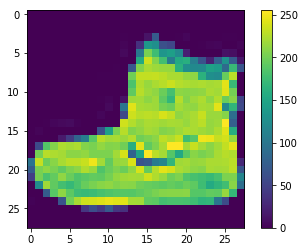

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

We scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [10]:
# train_images = train_images / 255.0

# test_images = test_images / 255.0

###Image Augmentation

Here we augment the images by rotating or flipping them. We create 2 augmentations per image.

In [11]:
# specifies the number of additional images that will be generated
number_of_augmentation = 2

# Defines the options for augmentation
# Types of Augmentation: rotation, horizontal flip, fill mode
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image):
    images = []
    # img height, img width, channels
    image = image.reshape(1, 28, 28, 1)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1024):
        images.append(x_batch)
        i += 1
        if i >= number_of_augmentation:
            break
    return images

In [12]:
def augment_data(train_data, test_data):
  X = []
  y = []
  for image, label in zip(train_data, test_data):
    # DATA AUGMENTATION
    argu_img = image_augmentation(image)
    for a in argu_img:
        # img height X img width
        X.append(a.reshape(28, 28))
        y.append(label)

    X.append(image)
    y.append(label)
  print('*Augmenting complete: %i samples\n' % len(X))
  return X, y

In [13]:
train_images_augmented, train_labels_augmented = augment_data(train_images, train_labels)

*Augmenting complete: 180000 samples



Now lets plot some images to see how our augmentations have changed them.

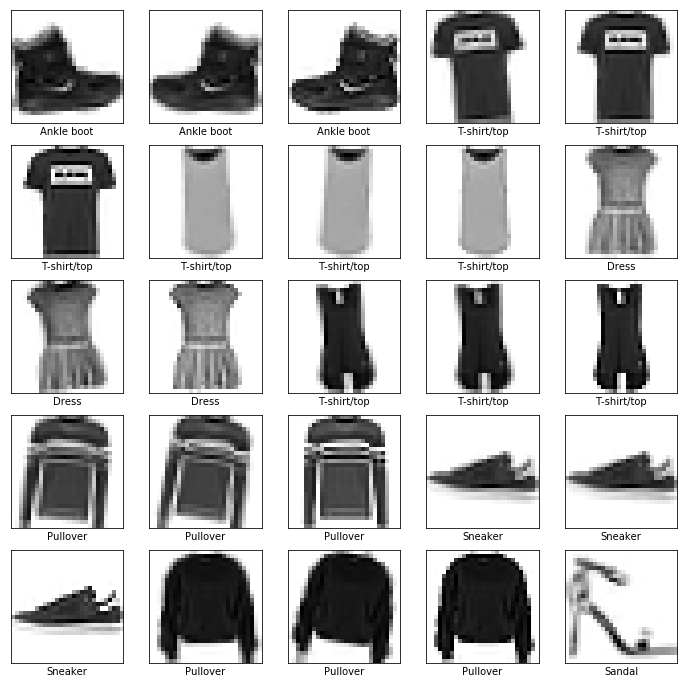

In [14]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_augmented[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels_augmented[i]])
plt.show()

###Shaping the data

In [15]:
# function to shape the data

def shaping(data, target):
  # convert to np array and set datatype 
  data = np.array(data, dtype=np.uint8)
  target = np.array(target, dtype=np.uint8)
  # reshape train data 
  data = data.reshape(data.shape[0], 28, 28, 1)
  target = np_utils.to_categorical(target, 10)
  # set train data to float
  data = data.astype('float32')
  # convert train data to values between 0 and 1
  data /= 255
  return data, target

In [16]:
train_images_shaped, train_labels_shaped  = shaping(train_images_augmented, train_labels_augmented)
test_images_shaped, test_labels_shaped    = shaping(test_images, test_labels)

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. And, hopefully, these representations are more meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have parameters that are learned during training.

In [17]:
# =============================================================================

model = keras.Sequential([
    # Set input shape
    keras.layers.InputLayer(input_shape=(28,28,1)),
    
    # Normalization
    keras.layers.BatchNormalization(-1),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(64, (4, 4), padding='same', activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Dropout
    keras.layers.Dropout(0.1),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(64, (4, 4), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Dropout
    keras.layers.Dropout(0.3),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    # Fully connected layer
    keras.layers.Dense(256, activation=tf.nn.relu),
    
    # Dropout
    keras.layers.Dropout(0.5),
    
    # Fully connected layer
    keras.layers.Dense(64, activation=tf.nn.relu),
    
    # Normalization
    keras.layers.BatchNormalization(-1),
    
    # Softmax
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

# =============================================================================

# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation=tf.nn.relu),
#     keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (of 28 by 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely-connected, or fully-connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer—this returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* *Loss function* —This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
* *Optimizer* —This is how the model is updated based on the data it sees and its loss function.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [18]:
tpu_model = model

tpu_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
tpu_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0

###Convert Keras model to TPU model

In [20]:
# # https://medium.com/tensorflow/tf-keras-on-tpus-on-colab-674367932aa0
# # Convert to TPU model
# import os
# # This address identifies the TPU we'll use when configuring TensorFlow.
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# tf.logging.set_verbosity(tf.logging.INFO)

# tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

# tpu_model.summary()

# # ==============================================================================
# # Compile tpu model

# tpu_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. We ask the model to make predictions about a test set—in this example, the `test_images` array. We verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [21]:
X_train, X_val, y_train, y_val = train_test_split(train_images_shaped, train_labels_shaped,
                                                      test_size=0.2, random_state=32)

In [22]:
history = tpu_model.fit(X_train, y_train, epochs=1, batch_size=1024, verbose=1, validation_data=(X_val, y_val))

Train on 144000 samples, validate on 36000 samples
144000/144000 [==============================] - 156s 1ms/sample - loss: 0.6752 - accuracy: 0.7606 - val_loss: 1.5263 - val_accuracy: 0.6848


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.96 on the training data and 0.96 on the validation data

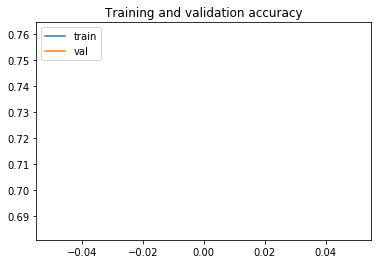

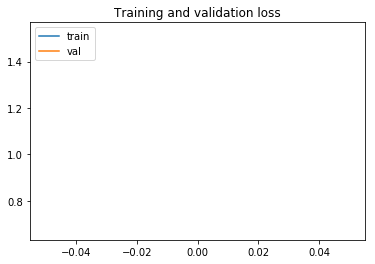

In [23]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [24]:
test_loss, test_acc = tpu_model.evaluate(test_images_shaped, test_labels_shaped)

print('Test accuracy:', test_acc)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Test accuracy: 0.7267


It turns out, the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*. Overfitting is when a machine learning model performs worse on new data than on their training data.

## Make predictions

With the model trained, we can use it to make predictions about some images.

In [25]:
predictions = tpu_model.predict(test_images_shaped)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [26]:
predictions[0]

array([0.06711728, 0.03865013, 0.08192031, 0.08031447, 0.0710704 ,
       0.06066144, 0.09060236, 0.10933128, 0.13527824, 0.26505405],
      dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [27]:
np.argmax(predictions[0])

9

So the model is most confident that this image is an ankle boot, or `class_names[9]`. And we can check the test label to see this is correct:

In [28]:
test_labels[0]

9

We can graph this to look at the full set of 10 channels

In [29]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

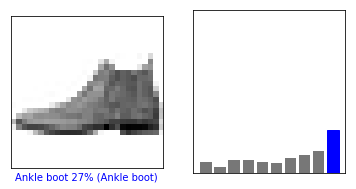

In [30]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

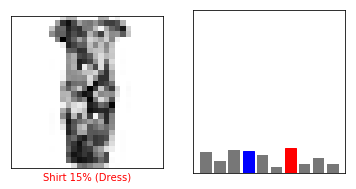

In [31]:
i = 100
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

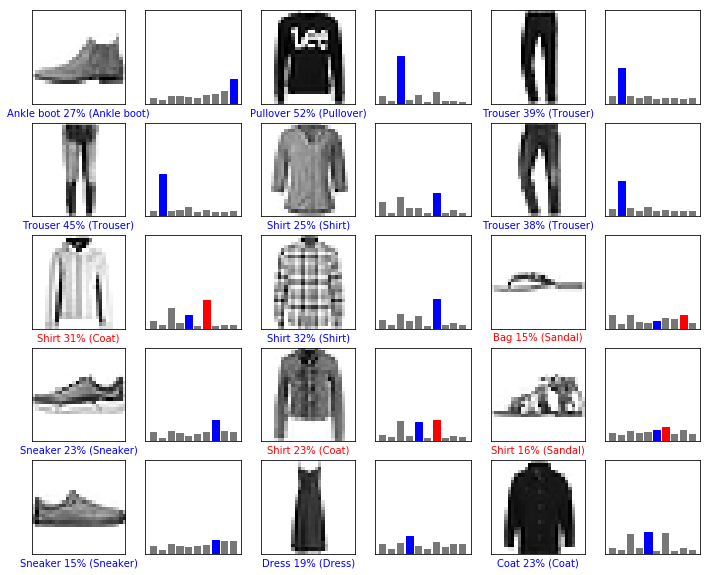

In [32]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()